In [2]:
# place any needed import statements at the top
import matplotlib.pyplot as plt
from numpy import linalg as LA
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from gplearn.genetic import SymbolicRegressor
import sys
import warnings

warnings.filterwarnings('ignore')

## Data Preprocessing

In [3]:
# Loading Dataset and Dropping Duplicate Rows
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz")
df = df.drop_duplicates(subset=['date_time'], ignore_index=True)

# Make holiday variable quantitative "dummy" using lambda expression
df['holiday'] = df['holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Make dummy variables for weather type
df = pd.get_dummies(df, columns=['weather_main'])
df.drop(['weather_main_Clear'], axis=1, inplace=True)
# Drop redundant feature
df.drop(columns = ['weather_description'], inplace = True)

# date_time does not work well currently, parse individual sections of it and create columns for it.
def parse_timestamp(df, datetime):
    df[datetime] = pd.to_datetime(df[datetime])
    df['Year'] = df[datetime].dt.year
    df['Month'] = df[datetime].dt.month
    df['Weekday'] = df[datetime].dt.weekday
    df['Hour'] = df[datetime].dt.hour
#This allows us to use each time section as its own feature. Hours we can see rush hour traffic, weekday to see vs weekends    
parse_timestamp(df, 'date_time')


## Exploratory Data

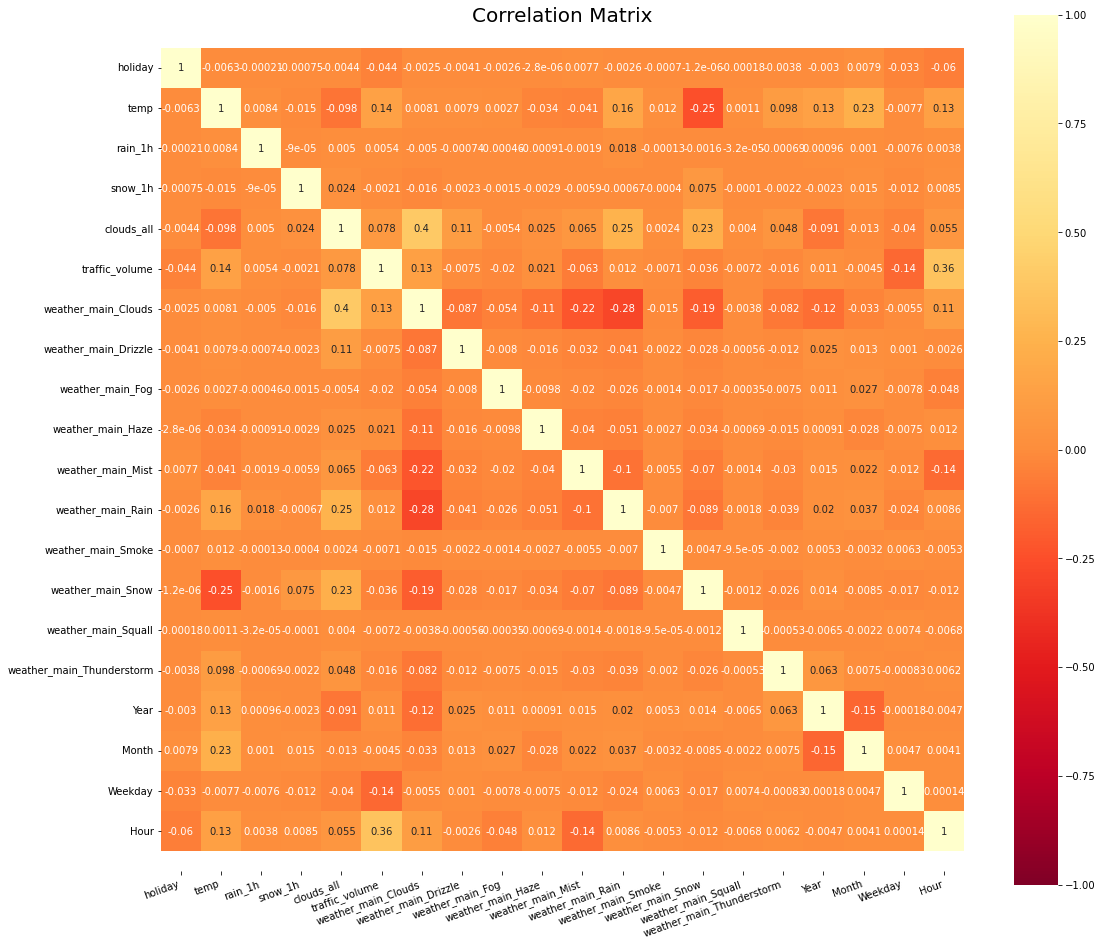

In [4]:
corr = df.corr()
plt.figure(figsize=(18,16))
ax = sns.heatmap(corr,vmin=-1, vmax=1, center=0, cmap='YlOrRd_r',square=True,annot=True)
bottom,top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=360)
ax.set_title('Correlation Matrix', fontsize=20)
plt.show()

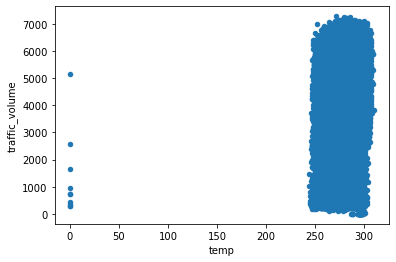

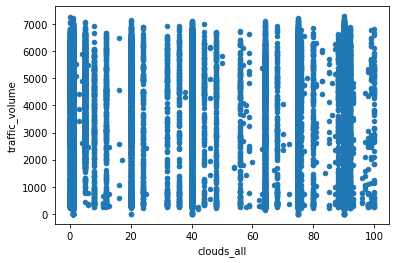

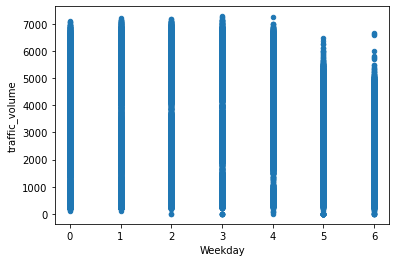

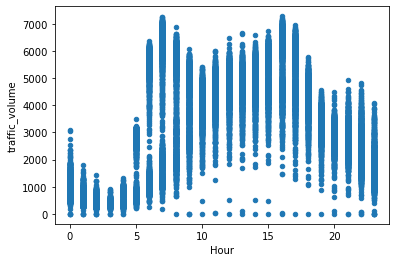

In [5]:
df.plot(x='temp', y = 'traffic_volume', kind='scatter')
plt.show()
df.plot(x='clouds_all', y = 'traffic_volume', kind='scatter')
plt.show()
df.plot(x='Weekday', y = 'traffic_volume', kind='scatter')
plt.show()
df.plot(x='Hour', y = 'traffic_volume', kind='scatter')
plt.show()

In [6]:
df.describe()

,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,Year,Month,Weekday,Hour
count,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000
mean,0.001306,281.316763,0.318632,0.000117,44.199162,3290.650474,0.372717,0.012693,0.004954,0.018879,0.075638,0.117535,0.000370,0.056611,0.000025,0.011165,2015.479729,6.489045,3.006778,11.514750
std,0.036119,13.816618,48.812640,0.005676,38.683447,1984.772909,0.483534,0.111945,0.070209,0.136098,0.264421,0.322061,0.019224,0.231101,0.004964,0.105072,1.888817,3.373618,1.998947,6.949889
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,0.000000,0.000000
25%,0.000000,271.840000,0.000000,0.000000,1.000000,1248.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,4.000000,1.000000,5.000000
50%,0.000000,282.860000,0.000000,0.000000,40.000000,3427.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,7.000000,3.000000,12.000000
75%,0.000000,292.280000,0.000000,0.000000,90.000000,4952.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,9.000000,5.000000,18.000000
max,1.000000,310.070000,9831.300000,0.510000,100.000000,7280.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2018.000000,12.000000,6.000000,23.000000


## Feature Selection

In [9]:
# Set dependent variable (all numeric columns expect target) and independent variables (target)
X = df[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
          'weather_main_Clouds', 'weather_main_Drizzle',
          'weather_main_Fog', 'weather_main_Haze', 'weather_main_Mist',
          'weather_main_Rain', 'weather_main_Smoke', 'weather_main_Snow',
          'weather_main_Squall', 'weather_main_Thunderstorm', 'Year','Month','Weekday','Hour']]
Y = df[['traffic_volume']]

# Add a column of ones to an array ('const' column)
X = sm.add_constant(X)


# Estimate the regression model unknown coefficients by using OLS function
model = sm.OLS(Y, X).fit()
print(model.summary())
print()

# Step: Remove 'weather_main_Mist' feature
print("# ===== Remove 'weather_main_Mist' feature =====")
X.drop(['weather_main_Mist'], axis=1, inplace=True)
model_1 = sm.OLS(Y, X).fit()
print(model_1.summary())
print()

# Step: Remove 'weather_main_Fog' feature
print("# ===== Remove 'weather_main_Fog' feature =====")
X.drop(['weather_main_Fog'], axis=1, inplace=True)
model_2 = sm.OLS(Y, X).fit()
print(model_2.summary())
print()

# Step: Remove 'weather_main_Snow' feature
print("# ===== Remove 'weather_main_Snow' feature =====")
X.drop(['weather_main_Snow'], axis=1, inplace=True)
model_3 = sm.OLS(Y, X).fit()
print(model_3.summary())
print()

# Step: Remove 'weather_main_Rain' feature
print("# ===== Remove 'weather_main_Rain' feature =====")
X.drop(['weather_main_Rain'], axis=1, inplace=True)
model_4 = sm.OLS(Y, X).fit()
print(model_4.summary())
print()

# Step: Remove 'rain_1h' feature
print("# ===== Remove 'rain_1h' feature =====")
X.drop(['rain_1h'], axis=1, inplace=True)
model_5 = sm.OLS(Y, X).fit()
print(model_5.summary())
print()

# Step: Remove 'weather_main_Squall' feature
print("# ===== Remove 'weather_main_Squall' feature =====")
X.drop(['weather_main_Squall'], axis=1, inplace=True)
model_6 = sm.OLS(Y, X).fit()
print(model_6.summary())
print()

# Step: Remove 'snow_1h' feature
print("# ===== Remove 'snow_1h' feature =====")
X.drop(['snow_1h'], axis=1, inplace=True)
model_7 = sm.OLS(Y, X).fit()
print(model_7.summary())
print()

# Step: Remove 'weather_main_Drizzle' feature
print("# ===== Remove 'weather_main_Drizzle' feature =====")
X.drop(['weather_main_Drizzle'], axis=1, inplace=True)
model_8 = sm.OLS(Y, X).fit()
print(model_8.summary())
print()

# Step: Remove 'weather_main_Smoke' feature
print("# ===== Remove 'weather_main_Smoke' feature =====")
X.drop(['weather_main_Smoke'], axis=1, inplace=True)
model_9 = sm.OLS(Y, X).fit()
print(model_9.summary())
print()

# Step: Remove 'Year' feature
print("# ===== Remove 'Year' feature =====")
X.drop(['Year'], axis=1, inplace=True)
model_10 = sm.OLS(Y, X).fit()
print(model_10.summary())
print()

                            OLS Regression Results                            
Dep. Variable:         traffic_volume   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     428.6
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:19:27   Log-Likelihood:            -3.6196e+05
No. Observations:               40575   AIC:                         7.240e+05
Df Residuals:                   40555   BIC:                         7.241e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

                            OLS Regression Results                            
Dep. Variable:         traffic_volume   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     581.6
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:19:28   Log-Likelihood:            -3.6196e+05
No. Observations:               40575   AIC:                         7.239e+05
Df Residuals:                   40560   BIC:                         7.241e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

##  Linear Regression

In [230]:
# Set dependent variable (all numeric columns expect target) and independent variables (target)
X = df[['holiday', 'temp', 'clouds_all', 'weather_main_Clouds', 'weather_main_Haze', 
        'weather_main_Thunderstorm', 'Month', 'Weekday', 'Hour']]
Y = df[['traffic_volume']]

# Add a column of ones to an array ('const' column)
X = sm.add_constant(X)

# Split the whole dataset into train set (80%) and test set (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False, test_size=0.2)

# Estimate the regression model unknown coefficients by using OLS function
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())
print()

# Estimate the regression model unknown coefficients by using OLS function
model = sm.OLS(Y_test, X_test).fit()
print(model.summary())
print()

regr = LinearRegression()
model = regr.fit(X_train, Y_train)
pred = regr.predict(X_train)
train_rmse = (np.sqrt(mean_squared_error(Y_train, pred)))
train_r2 = r2_score(Y_train, pred)

print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print()
print("Training set RMSE: ") 
print(train_rmse)
print("Training set R2: ") 
print(train_r2)

regr = LinearRegression()
regr.fit(X_train, Y_train)
pred = regr.predict(X_test)

test_rmse = (np.sqrt(mean_squared_error(Y_test, pred)))
test_r2 = r2_score(Y_test, pred)

print("Testing set RMSE: ") 
print(test_rmse)
print("Testing set R2: ") 
print(test_r2)

                            OLS Regression Results                            
Dep. Variable:         traffic_volume   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     720.1
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:09:37   Log-Likelihood:            -2.8964e+05
No. Observations:               32460   AIC:                         5.793e+05
Df Residuals:                   32450   BIC:                         5.794e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

## Ridge Regression

In [226]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)
regr_cv = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0])
model_cv = regr_cv.fit(X_train_std, Y_train)
pred_cv = regr_cv.predict(X_train_std)
train_cv_r2 = r2_score(Y_train, pred_cv)
print(model_cv.alpha_)
print("Training set R2: ") 
print(train_r2)
pred_test_cv = regr_cv.predict(X_test_std)
test_cv_r2 = r2_score(Y_test, pred_test_cv)
print("Testing set R2: ") 
print(test_cv_r2)

print()

regr_ridge = linear_model.Ridge(alpha=0.1)
model = regr_ridge.fit(X_train, Y_train)
pred = regr_ridge.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 0.1")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

print()

regr_ridge = linear_model.Ridge(alpha=1)
model = regr_ridge.fit(X_train, Y_train)
pred = regr_ridge.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 1")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

print()

regr_ridge = linear_model.Ridge(alpha=10)
model = regr_ridge.fit(X_train, Y_train)
pred = regr_ridge.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 10")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

print()

regr_ridge = linear_model.Ridge(alpha=100)
model = regr_ridge.fit(X_train, Y_train)
pred = regr_ridge.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 100")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)
pred = regr_ridge.predict(X_test)
test_r2 = r2_score(Y_test, pred)
print("Testing set R2: ") 
print(test_r2)

print()

regr_ridge = linear_model.Ridge(alpha=1000)
model = regr_ridge.fit(X_train, Y_train)
pred = regr_ridge.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 1000")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

print()

regr_ridge = linear_model.Ridge(alpha=10000)
model = regr_ridge.fit(X_train, Y_train)
pred = regr_ridge.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 10000")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

print()

regr_ridge = linear_model.Ridge(alpha=100000)
model = regr_ridge.fit(X_train, Y_train)
pred = regr_ridge.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha =100000")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

100.0
Training set R2: 
0.15614014684998312
Testing set R2: 
0.16986792385039418

alpha = 0.1
Intercept: [-2008.41411354]
Coefficients: [[ 0.00000000e+00 -1.57711236e+03  1.62580590e+01  1.49330908e+00
   2.83412777e+02  3.99952551e+02 -5.98046913e+02 -1.69066825e+01
  -1.45009448e+02  9.44277096e+01]]
Training set R2: 
0.16647586464455222

alpha = 1
Intercept: [-2008.20524653]
Coefficients: [[ 0.00000000e+00 -1.54463466e+03  1.62566285e+01  1.49319116e+00
   2.83380329e+02  3.99326232e+02 -5.96269210e+02 -1.69100566e+01
  -1.44989274e+02  9.44385531e+01]]
Training set R2: 
0.16647542250535508

alpha = 10
Intercept: [-2005.91876294]
Coefficients: [[    0.         -1280.83199115    16.24292922     1.49216268
    283.06594169   393.20509563  -579.12351477   -16.93794222
   -144.82375696    94.52752323]]
Training set R2: 
0.16644484995100628

alpha = 100
Intercept: [-1982.32836865]
Coefficients: [[   0.         -472.64193876   16.14297818    1.49148949  279.8768637
   341.44353796 -451.36

## Lasso Regression

In [219]:
regr_lasso = linear_model.Lasso(alpha=0.1)
model = regr_lasso.fit(X_train, Y_train)
pred = regr_lasso.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 0.1")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

print()

regr_lasso = linear_model.Lasso(alpha=1)
model = regr_lasso.fit(X_train, Y_train)
pred = regr_lasso.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 1")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

print()

regr_lasso = linear_model.Lasso(alpha=10)
model = regr_lasso.fit(X_train, Y_train)
pred = regr_lasso.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 10")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

print()

regr_lasso = linear_model.Lasso(alpha=20)
model = regr_lasso.fit(X_train, Y_train)
pred = regr_lasso.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 20")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

print()

regr_lasso = linear_model.Lasso(alpha=100)
model = regr_lasso.fit(X_train, Y_train)
pred = regr_lasso.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 100")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

regr_lasso = linear_model.Lasso(alpha=1000)
model = regr_lasso.fit(X_train, Y_train)
pred = regr_lasso.predict(X_train)
train_r2 = r2_score(Y_train, pred)
print("alpha = 1000")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Training set R2: ") 
print(train_r2)

print()

print("Selected Alpha: 10.0")
regr_lasso = linear_model.Lasso(alpha=10)
model = regr_lasso.fit(X_train, Y_train)
pred = regr_lasso.predict(X_test)
test_r2 = r2_score(Y_test, pred)
print("alpha = 10")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print("Testing set R2: ") 
print(test_r2)

alpha = 0.1
Intercept: [-2006.30270423]
Coefficients: [ 0.00000000e+00 -1.50466344e+03  1.62489749e+01  1.49451528e+00
  2.82917801e+02  3.94377112e+02 -5.87824512e+02 -1.69094092e+01
 -1.44942818e+02  9.44548005e+01]
Training set R2: 
0.16647352330338017

alpha = 1
Intercept: [-1987.09889548]
Coefficients: [   0.         -819.38553737   16.16579861    1.50525888  278.4301476
  343.57010561 -494.03886609  -16.93741267 -144.32252106   94.7097011 ]
Training set R2: 
0.16624126984952992

alpha = 10
Intercept: [-1861.95817431]
Coefficients: [   0.           -0.           15.70138495    1.688738    231.48356466
    0.           -0.          -16.6197669  -141.65821382   95.24015894]
Training set R2: 
0.16391299193636977

alpha = 20
Intercept: [-1856.66084061]
Coefficients: [   0.           -0.           15.66663594    1.93331569  181.98970996
    0.           -0.          -15.94896907 -139.10746996   95.2980872 ]
Training set R2: 
0.16351502686777108

alpha = 100
Intercept: [-1770.05197261]


##  Symbolic Regression

In [231]:
est = SymbolicRegressor()
est.fit(X_train, Y_train)
pred = est.predict(X_train)
print(pred)
train_r2 = r2_score(Y_train, pred)
print("Training set R2: ") 
print(train_r2)
pred = est.predict(X_test)
print(pred)
test_r2 = r2_score(Y_test, pred)
print("Testing set R2: ") 
print(test_r2)

[4033.90208008 4629.97672281 5024.38876662 ... 5325.62590332 5253.58016555
 5101.95631408]
Training set R2: 
0.4519646856651375
[5164.37909644 4512.49726018 4148.86355283 ... 3440.77949929 2976.80448306
 2321.0472542 ]
Testing set R2: 
0.44136424518098716


## Transformed Regression

Since there was no purpose in transorming my data as most of the variables were dummies or dates, I chose to polynomially transform my model. The results are shown in the code below.

In [10]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias = False) # the initial columns of 1's not needed for LinearRegression()
X2_train = poly.fit_transform(X_train)
X2_test = poly.fit_transform(X_test)

regr = LinearRegression()
model = regr.fit(X2_train, Y_train)
pred = regr.predict(X2_train)

train2_rmse = (np.sqrt(mean_squared_error(Y_train, pred)))
train2_r2 = r2_score(Y_train, pred)

print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print()
print("Quadratic Training set RMSE: ") 
print(train2_rmse)
print("Quadratic Training set R2: ") 
print(train2_r2)

regr = LinearRegression()
regr.fit(X2_train, Y_train)
pred = regr.predict(X2_test)

test2_rmse = (np.sqrt(mean_squared_error(Y_test, pred)))
test2_r2 = r2_score(Y_test, pred)

print("Quadratic Testing set RMSE: ") 
print(test2_rmse)
print("Quadratic Testing set R2: ") 
print(test2_r2)

Intercept: [85291311.90612774]
Coefficients: [[ 1.12700686e-04 -7.33134886e+03  2.66251917e+03  1.22427838e+04
  -7.42949653e-02 -2.07891796e+01 -3.39380662e+02 -7.22555996e+03
  -5.72908324e+04  7.96059820e+03  1.93750343e+04  1.31681397e+04
  -7.83966932e-02  1.21225936e+04  8.82155023e-05  7.87976209e+03
  -4.26986013e+04 -8.30502559e+02 -4.32782996e+03  7.31021506e+02
  -7.83871974e-08 -7.33134886e+03  2.66251908e+03  1.22427838e+04
  -7.42932328e-02 -2.07891800e+01 -3.39380662e+02 -7.22555996e+03
  -5.72908324e+04  7.96059821e+03  1.93750343e+04  1.31681397e+04
  -7.83967324e-02  1.21225936e+04  8.80680562e-05  7.87976209e+03
  -4.26986013e+04 -8.30502559e+02 -4.32782996e+03  7.31021506e+02
  -7.33134886e+03 -1.62575980e+00  3.49167722e+02  7.55903784e-09
   1.34922922e+00 -1.26281053e+02 -4.73534101e-10  1.18557750e-08
   6.16166305e+02 -1.11078384e+02 -2.65643671e+02  1.58680677e-08
   2.97266950e+02 -3.29284831e-08 -6.94512892e-09  1.18067980e+01
  -1.47354074e+01  1.72046920e+

In [216]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3, include_bias = False) # the initial columns of 1's not needed for LinearRegression()
X3_train = poly.fit_transform(X_train)
X3_test = poly.fit_transform(X_test)

regr = LinearRegression()
model = regr.fit(X3_train, Y_train)
pred = regr.predict(X3_train)

train3_rmse = (np.sqrt(mean_squared_error(Y_train, pred)))
train3_r2 = r2_score(Y_train, pred)

print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print()
print("Cubic Training set RMSE: ") 
print(train3_rmse)
print("Cubic Training set R2: ") 
print(train3_r2)

regr = LinearRegression()
regr.fit(X3_train, Y_train)
pred = regr.predict(X3_test)

test3_rmse = (np.sqrt(mean_squared_error(Y_test, pred)))
test3_r2 = r2_score(Y_test, pred)

print("Cubic Testing set RMSE: ") 
print(test3_rmse)
print("Cubic Testing set R2: ") 
print(test3_r2)

Intercept: [-4024.88936885]
Coefficients: [[ 4.83466277e-05 -4.04895163e+03  1.88002619e+01  1.08371885e+01
  -1.79230076e+03  4.73896878e+03 -4.78232024e+04  5.02458220e+02
   5.15625393e+02  1.85766931e+02  1.14825890e-05 -4.04895161e+03
   1.88001648e+01  1.08373629e+01 -1.79230071e+03  4.73896861e+03
  -4.78232023e+04  5.02458072e+02  5.15625498e+02  1.85766992e+02
  -4.04895155e+03  5.41018716e+01  2.77352826e+01 -6.94062682e+02
  -1.29301035e-02  3.27630844e-06 -8.53060723e+01  1.59684197e+03
   6.95035329e-06 -1.78091715e-01 -1.27662355e-01  2.74782368e+01
  -7.09364825e+01  6.36103055e+02  9.76251278e-01 -4.71890434e+00
   5.86700129e-01 -1.59925427e-02  2.67615905e+00 -1.53359257e+01
   5.48050920e+01 -2.03432746e+00 -4.15511482e-01  1.05068595e+00
  -1.79230066e+03 -4.56676091e-07 -1.93305542e-07  4.57614709e+01
  -3.56433673e+01 -5.01954056e+01  4.73896862e+03 -4.12585124e-07
   7.26665693e+01  3.66385706e+01  4.88363366e+01 -4.78232023e+04
   4.17353151e+02 -8.63289590e+01 

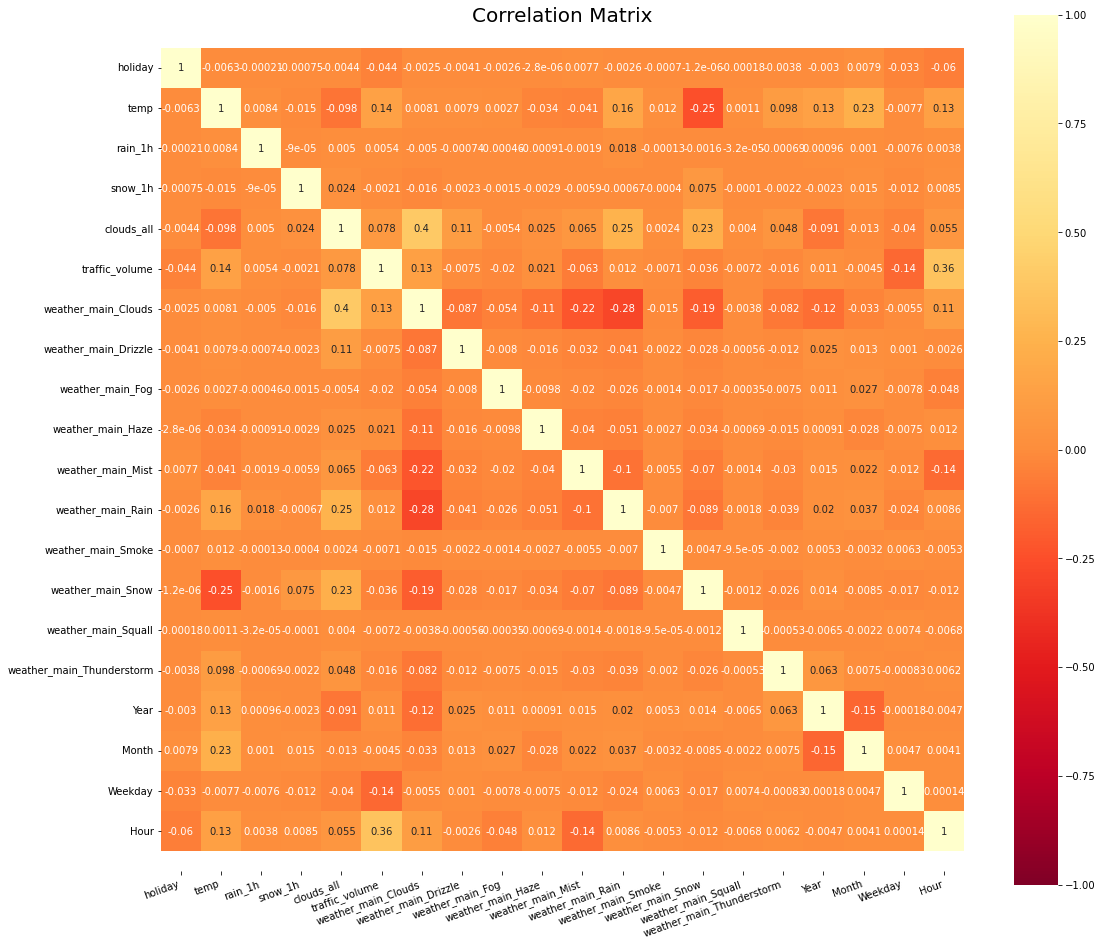

In [232]:
corr = df.corr()
plt.figure(figsize=(18,16))
ax = sns.heatmap(corr,vmin=-1, vmax=1, center=0, cmap='YlOrRd_r',square=True,annot=True)
bottom,top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=360)
ax.set_title('Correlation Matrix', fontsize=20)
plt.show()